In [1]:
!pip install ortools

In [2]:
#SCREAM : https://scxscream.herokuapp.com/home/
from ortools.sat.python import cp_model
import sys
import numpy as np
import logging
logging.basicConfig()
LOG = logging.getLogger()
LOG.setLevel(logging.INFO)
logHandler = logging.StreamHandler(sys.stderr)
logHandler.setFormatter(logging.Formatter('%(asctime)s-%(name)s-%(levelname)s-%(message)s'))
LOG.handlers=[logHandler]
INFINITY = cp_model.INT32_MAX

#helper functions
#we take profit of the broadcast capabilities of numpy with the np.vectorize function. It works very well with or-tools variables
add_constraint=lambda model:model.Add
add_constraints_eq=lambda model:np.vectorize(lambda e,c : model.Add(e==c), otypes=[object])
add_constraints_ge=lambda model:np.vectorize(lambda e,c : model.Add(e>=c), otypes=[object])
add_constraints_le=lambda model:np.vectorize(lambda e,c : model.Add(e<=c), otypes=[object])
vararray_to_results=lambda solver:lambda var_array:np.vectorize(lambda v:solver.Value(v), otypes=[object])(var_array)
sum_results=lambda solver:lambda var_array:np.sum(np.vectorize(lambda v:solver.Value(v), otypes=[object])(var_array))
find_chosen_var=lambda solver:lambda bool_var_array:[v.Name() for v in bool_var_array if solver.Value(v) ]


# PROBLEM CONSTANTS
NUMBER_OF_WEEKS=52
PERIODS=range(0,NUMBER_OF_WEEKS)
MAX_QUANTITY=52*100*2
OBJECTIVE_SCALE=100  #for dealing with cents due to non integer holding costs 

# ensure we always have the same results
RANDOM=np.random.default_rng(0)


In [3]:
class PowerLawDistribution:
    '''
    Produce a discrete Power Law Distribution (zipf) given an expected mean.
    As it is a very turbulent distribution, we may need to try hundreds time before finding a good draw matching the expected mean
    The class starts by creating a look up table to find which parameter could match the expected mean
    '''
    def __init__(self, N):
        self.LOG=LOG.getChild("PowerLawDistribution")
        self.LOG.info(f'initializing...')
        self.N=N
        self.param_lookup=np.arange(1.1, 10.00, 0.01)
        self.mean_lookup=np.asarray([np.mean(np.clip(RANDOM.zipf(s, N*500)-1, None, N)) for s in self.param_lookup])
        self.LOG.debug(f'param={self.param_lookup}->µ={self.mean_lookup}')
        self.LOG.info(f'initialized...')
    def Generate(self, mean, count=1, max_attempts=1000, tolerance=0.1):
        if mean <0 : 
            raise ValueError("mean should be positive")
        if count<1 :
            raise ValueError("count should be >= 1")
        s=self.param_lookup[np.abs(self.mean_lookup-mean).argmin()]
        nb_attempt=0
        while True: 
            r=np.clip(RANDOM.zipf(s, count)-1, None, self.N)
            µ=np.mean(r)
            nb_attempt+=1
            if (max_attempts is None or abs(mean-µ)/(mean if mean > 0.1 else 0.1)<=tolerance):  
                self.LOG.debug(f"found distribution with mean {µ} (excepted {mean}) after {max_attempts}")
                return r
            elif nb_attempt>=max_attempts:
                raise ValueError(f"Cannot find generate a distribution with mean {mean} within {max_attempts} attempts (latest:{µ})")
        self.LOG.info(f'requested mean{mean}, produced mean={np.mean(r)}')
        return r

POWER_LAW=PowerLawDistribution(NUMBER_OF_WEEKS)

import unittest
class TestPowerLawDistribution(unittest.TestCase):
    def setUp(self):
        self.pld=PowerLawDistribution(5)
    def test_mean_0(self):
        self.assertTrue((self.pld.Generate(mean=0, count=5)==[0, 0, 0, 0, 0]).all())
    def test_mean_1(self):
        self.assertEqual(np.mean(self.pld.Generate(mean=1, count=5)),1.0)

#unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestPowerLawDistribution))

2021-10-26 09:44:31,431-PowerLawDistribution-INFO-initializing...
2021-10-26 09:44:37,123-PowerLawDistribution-INFO-initialized...


In [4]:
def BuildScenarios(count,
                   disruptionSupplierDurationMean=2, disruptionPlantDurationMean=2, disruptionDCDurationMean=2,
                   meanDemand=100, stdDevDemand=10, weeks=NUMBER_OF_WEEKS):
    '''
    Build various scenarios according to parameters
    '''
    LOG=globals()["LOG"].getChild("BuildScenarios")
    LOG.info(f'starting...')
    scenarios=[]
    supplierDisruptionDurations = POWER_LAW.Generate(disruptionSupplierDurationMean, count) 
    plantDisruptionDurations = POWER_LAW.Generate(disruptionPlantDurationMean, count) 
    dcDisruptionDurations = POWER_LAW.Generate(disruptionDCDurationMean, count) 
    def get_disruption_range(d):
        if d==0:
            return range(0)
        else:
            start=RANDOM.integers(0, max(weeks-d, 1))
            return range(start, min(start+d, weeks))
    
    for i in range(0, count):
        scenarios.append({
            "Name":f'Scenario_{i}',
            "IsActive":True,
            "DisruptionSupplier":get_disruption_range(supplierDisruptionDurations[i]),
            "DisruptionPlant":get_disruption_range(plantDisruptionDurations[i]),
            "DisruptionDC":get_disruption_range(dcDisruptionDurations[i]),
            "Demand":np.rint(RANDOM.normal(meanDemand, stdDevDemand, size=weeks)).astype(int)
        })
    LOG.info(f'done')
    return scenarios

import unittest
class TestBuildScenarios(unittest.TestCase):
    def test_durations(self):
        global RANDOM
        RANDOM=np.random.default_rng(0)
        s=BuildScenarios(1, 0, 5, 10, 100, 0, 50)[0]
        self.assertEqual(len(s["DisruptionSupplier"]), 0)
        self.assertLessEqual(abs(len(s["DisruptionPlant"])-1), 5, 1)
        self.assertLessEqual(abs(len(s["DisruptionDC"])-10), 10)
        
#unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestBuildScenarios))

In [5]:
class MasterModel:
    '''
    The Master Model contains the global decision variables of the problem. 
    They will be used inside each Child Model.
    One Child Model is generated by scenario
    '''
    def __init__(self, scenarios, missedSalePenalty=0, weeklyHoldingCost=0.25/52, allowBackupPolicies=True):
        self.LOG=LOG.getChild("MasterModel")
        self.LOG.info(f'Initializing for {len(scenarios)} scenarios, missedSalePenalty={missedSalePenalty}...')
        self.Model=cp_model.CpModel()
        model=self.Model
        self.solver = None

        self.Scenarios=scenarios
        self.MissedSalePenalty=missedSalePenalty
        self.FGRetailPrice=135
        self.WIPCost=50
        self.WIPConversionCost=20
        self.FGCost=self.WIPCost+self.WIPConversionCost
        self.WeeklyHoldingCost=weeklyHoldingCost
        self.SupplierCapacity=150
        self.PlantCapacity=150
        self.DCCapacity=126
        self.BackupPolicies=range(0,6)
        self.BackupSupplierPolicies={
            "Capacity":[ 0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[3000, 5000, 7000, 7000, 8000, 9000],
            "SetupCost":[2000, 4000, 8000, 3000, 6000, 8000],
            "VariableCost":np.array([10, 10, 10, 5, 5, 5])
        }
        self.BackupPlantPolicies={
            "Capacity":[0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[2000, 4000, 6000, 6000, 8000, 10000],
            "SetupCost":[1000, 2000, 4000, 2000, 4000, 8000],
            "VariableCost":np.array([15, 15, 15, 10, 10, 10])
        }
        self.BackupDCPolicies={
            "Capacity":[0.5, 0.5, 0.5, 1, 1, 1],
            "ResponseTime":[4, 2, 1, 6, 2, 1],
            "OptionCost":[5000, 7000, 9000, 11000, 13000, 15000],
            "SetupCost":[5000, 10000, 15000, 5000, 10000, 15000],
            "VariableCost":np.array([25, 25, 25, 20, 20, 20]),
        }

        #Decision Variables
        self.WIPBackupInventoryInitialLevel=model.NewIntVar(0, INFINITY, f'BackupWIPInventoryLevel')
        self.FGBackupInventoryInitialLevel=model.NewIntVar(0, INFINITY, f'BackupFGInventoryLevel')
        self.BackupSupplierPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupSupplierPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy in self.BackupPolicies))
        self.BackupPlantPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupPlantPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy  in self.BackupPolicies))
        self.BackupDCPolicyIsChoosen=np.asarray(list(model.NewBoolVar(f'BackupDCPolicyIsChoosen{policy}(SCREAM n°{policy+2})') for policy  in self.BackupPolicies))
        self.WIPInventoryAtPlantsInitialLevel=model.NewIntVar(0, INFINITY, f'WIPInventoryAtPlantsInitialLevel')
        self.FGInventoryAtPlantInitialLevel=model.NewIntVar(0, INFINITY, f'FGInventoryAtPlantInitialLevel')
        self.FGInventoryAtDCsInitialLevel=model.NewIntVar(0, INFINITY, f'FGInventoryAtDCsInitialLevel')
        
        #GLOBAL CONSTRAINTS
        #At maximum, only one Backup Policy chosen
        add_constraints_le(model)(np.sum(self.BackupSupplierPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        add_constraints_le(model)(np.sum(self.BackupPlantPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        add_constraints_le(model)(np.sum(self.BackupDCPolicyIsChoosen), 1 if allowBackupPolicies else 0)
        self.LOG.info("Initializing ChildModels for each scenario...")
        self.ChildModels=[ChildModel(self, scenario) for scenario in self.Scenarios if scenario["IsActive"]]
        self.LOG.info("ChildModels initialized")
        
        # as we work in a just in time Supply Chain, we suppose no inventory at the beginning 
        add_constraints_le(model)(self.WIPInventoryAtPlantsInitialLevel, 0)
        add_constraints_le(model)(self.FGInventoryAtPlantInitialLevel, 0)
        add_constraints_le(model)(self.FGInventoryAtDCsInitialLevel, 0)
        
        self.TotalObjectiveFunction=np.sum([m.ObjectiveFunction for m in self.ChildModels])
        self.TotalProfit=np.sum([m.Profit for m in self.ChildModels])  
        self.TotalSoldUnits=np.sum([m.SumFGToCustomer for m in self.ChildModels])
        self.TotalDemand=np.sum([m.Scenario["Demand"] for m in self.ChildModels])
        self.TotalCosts=np.sum([m.TotalCosts for m in self.ChildModels])
        model.Maximize(self.TotalObjectiveFunction)

        self.LOG.debug("Model Stats:")
        self.LOG.debug(model.ModelStats())
        
        self.LOG.info("Initiliazed")
    def Solve(self):
        self.LOG.info("Solving...")
        solver=self.Solver=cp_model.CpSolver()
        model=self.Model
        status = solver.Solve(model)
        self.LOG.info(f'Solved. Status : {solver.StatusName()}')
        self.LOG.debug("Response Stats:")
        self.LOG.debug(solver.ResponseStats())

        if status == cp_model.OPTIMAL:
            self.Results={
                "TotalObjectiveFunction":solver.Value(self.TotalObjectiveFunction),
                "TotalProfit":solver.Value(self.TotalProfit)/OBJECTIVE_SCALE,
                "AverageProfit":solver.Value(self.TotalProfit)/(OBJECTIVE_SCALE*len(self.ChildModels)),
                "TotalSoldUnits":solver.Value(self.TotalSoldUnits),
                "TotalCosts":solver.Value(self.TotalCosts),
                "TotalDemand":self.TotalDemand,
                "ItemFillRate":solver.Value(self.TotalSoldUnits)/self.TotalDemand,
                "WIPBackupInventoryInitialLevel":solver.Value(self.WIPBackupInventoryInitialLevel),
                "FGBackupInventoryInitialLevel":solver.Value(self.FGBackupInventoryInitialLevel),
                "WIPInventoryAtPlantsInitialLevel":solver.Value(self.WIPInventoryAtPlantsInitialLevel),
                "FGInventoryAtPlantInitialLevel":solver.Value(self.FGInventoryAtPlantInitialLevel),
                "FGInventoryAtDCsInitialLevel":solver.Value(self.FGInventoryAtDCsInitialLevel),
                "BackupSupplierPolicyIsChoosen":find_chosen_var(solver)(self.BackupSupplierPolicyIsChoosen),
                "BackupPlantPolicyIsChoosen":find_chosen_var(solver)(self.BackupPlantPolicyIsChoosen),
                "BackupDCPolicyIsChoosen":find_chosen_var(solver)(self.BackupDCPolicyIsChoosen),
            }
            self.LOG.debug(self.Results)
            self.ChildResults=[sm.ComputeResults() for sm in self.ChildModels]
            return self.Results
        else:
            self.LOG.error(solver.StatusName())
            self.LOG.error(model.Validate())

class ChildModel:
    def __init__(self, masterModel, scenario):
        self.LOG=LOG.getChild("ChildModel")
        #Model
        self.LOG.debug(f'Initializing for scenario {scenario["Name"]}...')
        master=self.MasterModel= masterModel
        model=master.Model
        self.Scenario=scenario
        self.WIPFromSupplier=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPFromSupplier{period}') for period in PERIODS))
        self.WIPFromBackupInventory=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPFromBackupInventory{period}') for period in PERIODS))
        self.WIPBackupInventoryLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPBackupInventoryLevel{period}') for period in PERIODS))
       # self.WIPBackupInventoryLevelIsNotEmpty=np.asarray(list(model.NewBoolVar(f'WIPBackupInventoryLevelIsNotEmpty{period}') for period in PERIODS))
        self.BackupSupplierWasActivated=np.asarray(list(model.NewBoolVar(f'BackupSupplierWasActivated{policy}') for policy in master.BackupPolicies))
        self.WIPFromBackupSupplier=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'WIPFromBackupSupplier{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        self.SumWIPToPlants=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumWIPToPlants{period}') for period in PERIODS))
        
        #we consider Main Plant and backup Plant share the same WIP Inventory
        self.WIPInventoryAtPlantsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPInventoryAtPlantsLevel{period}') for period in PERIODS))
        self.WIPToFGAtPlant=np.asarray(list(model.NewIntVar(0, INFINITY, f'WIPToFGAtPlant{period}') for period in PERIODS))
        self.WIPToFGAtBackupPlant=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'WIPToFGAtBackupPlant{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        #we consider Main Plant and backup Plant share the same FG Inventory
        self.FGInventoryAtPlantsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGInventoryAtPlantsLevel{period}') for period in PERIODS))
        self.FGFromPlants=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromPlants{period}') for period in PERIODS))
        self.BackupPlantWasActivated=np.asarray(list(model.NewBoolVar(f'BackupPlantWasActivated{policy}') for policy in master.BackupPolicies))
        self.SumFGToDC=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumFGToDC{period}') for period in PERIODS))

        #we consider Main DC and backup DC share the same FG Inventory
        self.FGInventoryAtDCsLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGInventoryAtDCsLevel{period}') for period in PERIODS))
        self.FGFromBackupInventory=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromBackupInventory{period}') for period in PERIODS))
        self.FGBackupInventoryLevel=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGBackupInventoryLevel{period}') for period in PERIODS))
        self.FGBackupInventoryLevelIsNotEmpty=np.asarray(list(model.NewBoolVar(f'FGBackupInventoryLevelIsNotEmpty{period}') for period in PERIODS))
        self.BackupDCWasActivated=np.asarray(list(model.NewBoolVar(f'BackupDCWasActivated{policy}') for policy in master.BackupPolicies))
        self.FGFromBackupDC=np.asarray(list(list(model.NewIntVar(0, INFINITY, f'FGFromBackupDC{period}_{policy}') for period in PERIODS) for policy in master.BackupPolicies))
        self.FGFromDC=np.asarray(list(model.NewIntVar(0, INFINITY, f'FGFromDC{period}') for period in PERIODS))
        self.SumFGToCustomer=np.asarray(list(model.NewIntVar(0, INFINITY, f'SumFGToCustomer{period}') for period in PERIODS))
  
        self.UnsatisfiedDemand=np.asarray(list(model.NewIntVar(0, INFINITY, f'UnsatisfiedDemand{period}') for period in PERIODS))

        #Authorize flows from Backup Entity only "Responsetime" weeks after disruption
        #Add linking constraint to BackupXXXActivated to enforce this booleanVar to be True is activated
        #note : we add one to the response time because in the scream simulator, a backup facility with response time 1 does not work for 2 weeks
        for policy in master.BackupPolicies:
            for p in PERIODS:
                if (p-(master.BackupSupplierPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionSupplier"] or p not in scenario["DisruptionSupplier"]):
                    add_constraint(model)(self.WIPFromBackupSupplier[policy][p]<=0)
                if (p-(master.BackupPlantPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionPlant"] or p not in scenario["DisruptionPlant"]):
                    add_constraint(model)(self.WIPToFGAtBackupPlant[policy][p]<=0)
                if (p-(master.BackupDCPolicies["ResponseTime"][policy]+1) not in scenario["DisruptionDC"] or p not in scenario["DisruptionDC"]):
                    add_constraint(model)(self.FGFromBackupDC[policy][p]<=0)
                add_constraint(model)(self.WIPFromBackupSupplier[policy][p]<=(self.BackupSupplierWasActivated[policy]*round(master.SupplierCapacity*master.BackupSupplierPolicies["Capacity"][policy])))   
                add_constraint(model)(self.WIPToFGAtBackupPlant[policy][p]<=(self.BackupPlantWasActivated[policy]*round(master.PlantCapacity*master.BackupPlantPolicies["Capacity"][policy])))
                add_constraint(model)(self.FGFromBackupDC[policy][p]<=(self.BackupDCWasActivated[policy]*round(master.DCCapacity*master.BackupDCPolicies["Capacity"][policy])))

        #We don't enforce the rule "When a disruption hits, you attempt to use all of your backup inventory before making a decision to invoke your option and pay a setup cost.".
        #Indeed, as each unit going through Backup facility will suffer Variable Costs, MILP will always try to consume the backup inventory first.
        #add_constraints_le(model)(self.WIPBackupInventoryLevel, self.WIPBackupInventoryLevelIsNotEmpty*MAX_QUANTITY)
        #add_constraints_le(model)(self.FGBackupInventoryLevel, self.FGBackupInventoryLevelIsNotEmpty*MAX_QUANTITY)
        #add_constraints_le(model)(np.sum(self.WIPFromBackupSupplier, axis=0), (1-self.WIPBackupInventoryLevelIsNotEmpty)*MAX_QUANTITY)
        #add_constraints_le(model)(np.sum(self.WIPToFGAtBackupPlant+self.FGFromBackupDC, axis=0), (1-self.FGBackupInventoryLevelIsNotEmpty)*MAX_QUANTITY) 
                
        #flow from backup entity allowed only if policy was chosen
        add_constraints_le(model)(np.sum(self.WIPFromBackupSupplier, axis=1), master.BackupSupplierPolicyIsChoosen*MAX_QUANTITY)
        add_constraints_le(model)(np.sum(self.WIPToFGAtBackupPlant, axis=1), master.BackupPlantPolicyIsChoosen*MAX_QUANTITY)
        add_constraints_le(model)(np.sum(self.FGFromBackupDC, axis=1), master.BackupDCPolicyIsChoosen*MAX_QUANTITY)

        #DISRUPTIONS
        #forbid flow during disruption
        add_constraints_le(model)(self.WIPFromSupplier[scenario["DisruptionSupplier"]], 0) # no shipment if Supplier is disrupted
        add_constraints_le(model)(self.WIPToFGAtPlant[scenario["DisruptionPlant"]], 0) # no conversion if Plant is disrupted
        add_constraints_le(model)(self.FGFromDC[scenario["DisruptionDC"]], 0) # no reception if DC is disrupted

        #Forbid flows from [WIP/FG]BackupInventory outside  disruption
        # for FGBackupInventory : it is allowed as soon as we are in a Plant Disruption or DC Disruption
        add_constraints_le(model)(self.WIPFromBackupInventory[[p for p in PERIODS if p not in scenario["DisruptionSupplier"]]], 0)
        add_constraints_le(model)(self.FGFromBackupInventory[[p for p in PERIODS if p not in scenario["DisruptionPlant"] and p not in scenario["DisruptionDC"]]], 0)

        #Forbid facility to anticipate disruption (which MILP will try to do by provisionning inventory at the lowest cost)
        #flows cannot be greater than the past demand
        for p in PERIODS:
            add_constraints_le(model)(self.SumWIPToPlants[range(0, p)], scenario["Demand"][range(0, p)])
            add_constraints_le(model)(self.SumFGToDC[range(0, p)], scenario["Demand"][range(0, p)])
                   
        #FLOW CONSTRAINTS
        #maximum output flow 
        add_constraints_le(model)(self.WIPFromSupplier, master.SupplierCapacity)
        add_constraints_le(model)(self.WIPInventoryAtPlantsLevel, master.PlantCapacity)
        add_constraints_le(model)(self.WIPToFGAtPlant, master.PlantCapacity)
        add_constraints_le(model)(self.FGInventoryAtPlantsLevel, master.PlantCapacity)
        add_constraints_le(model)(self.FGInventoryAtDCsLevel, master.DCCapacity)
        add_constraints_le(model)(self.FGFromDC, master.DCCapacity)
        
        #Flow equilibrium
        # flow balance between total FG delivered and demand
        # flows to customer come only from DC, FGBackupInventory, or BackupDC
        add_constraints_eq(model)(self.SumFGToCustomer, self.FGFromDC+self.FGFromBackupInventory+np.sum(self.FGFromBackupDC, axis=0))
        add_constraints_eq(model)(self.SumFGToCustomer, scenario["Demand"]-self.UnsatisfiedDemand)

        # flow balance at DCs
        # flows to DCs come only from plants
        # goods are delivered either from MainDC or from a Backup DC
        add_constraints_eq(model)(self.SumFGToDC, self.FGFromPlants)
        add_constraint(model)(self.FGInventoryAtDCsLevel[0]==master.FGInventoryAtDCsInitialLevel-self.FGFromDC[0]-np.sum(self.FGFromBackupDC, axis=0)[0]+self.SumFGToDC[0])       
        add_constraints_eq(model)(self.FGInventoryAtDCsLevel[1:], self.FGInventoryAtDCsLevel[:-1]-self.FGFromDC[1:]-np.sum(self.FGFromBackupDC, axis=0)[1:]+self.SumFGToDC[1:])       

        #flow balance at Plant
        # WIP flows to Plants come only from Supplier, Backup Inventory or Backup Supplier
        # conversion from WIP to FG can be done either at the main Plant or at the backupPlant
        # goods are delivered by either the main Plant or the backup Plant
        add_constraints_eq(model)(self.SumWIPToPlants, self.WIPFromSupplier+self.WIPFromBackupInventory+np.sum(self.WIPFromBackupSupplier, axis=0))
        add_constraint(model)(self.WIPInventoryAtPlantsLevel[0]==master.WIPInventoryAtPlantsInitialLevel-self.WIPToFGAtPlant[0]-np.sum(self.WIPToFGAtBackupPlant, axis=0)[0]+self.SumWIPToPlants[0])       
        add_constraints_eq(model)(self.WIPInventoryAtPlantsLevel[1:], self.WIPInventoryAtPlantsLevel[:-1]-self.WIPToFGAtPlant[1:]-np.sum(self.WIPToFGAtBackupPlant, axis=0)[1:]+self.SumWIPToPlants[1:])       
        add_constraint(model)(self.FGInventoryAtPlantsLevel[0]==master.FGInventoryAtPlantInitialLevel-self.FGFromPlants[0]+self.WIPToFGAtPlant[0]+np.sum(self.WIPToFGAtBackupPlant, axis=0)[0])       
        add_constraints_eq(model)(self.FGInventoryAtPlantsLevel[1:], self.FGInventoryAtPlantsLevel[:-1]-self.FGFromPlants[1:]+self.WIPToFGAtPlant[1:]+np.sum(self.WIPToFGAtBackupPlant, axis=0)[1:])     

        # flow balance for inventory backup
        add_constraint(model)(self.WIPBackupInventoryLevel[0]==master.WIPBackupInventoryInitialLevel-self.WIPFromBackupInventory[0])
        add_constraints_eq(model)(self.WIPBackupInventoryLevel[1:], self.WIPBackupInventoryLevel[:-1]-self.WIPFromBackupInventory[1:])
        add_constraint(model)(self.FGBackupInventoryLevel[0]==master.FGBackupInventoryInitialLevel-self.FGFromBackupInventory[0])       
        add_constraints_eq(model)(self.FGBackupInventoryLevel[1:], self.FGBackupInventoryLevel[:-1]-self.FGFromBackupInventory[1:])
        
        
        #OBJECTIVE FUNCTION
        self.PurchaseCosts=np.sum((self.WIPFromSupplier+np.sum(self.WIPFromBackupSupplier, axis=0))*master.WIPCost) * OBJECTIVE_SCALE
        self.ProductionCosts=np.sum((self.WIPToFGAtPlant+np.sum(self.WIPToFGAtBackupPlant, axis=0))*master.WIPConversionCost) * OBJECTIVE_SCALE
        self.InitialInventoryCosts=(
            master.WIPInventoryAtPlantsInitialLevel*master.WIPCost+
            master.FGInventoryAtPlantInitialLevel*master.FGCost+
            master.FGInventoryAtDCsInitialLevel*master.FGCost) * OBJECTIVE_SCALE
        
        self.BackupInventoryCosts=(
            master.WIPBackupInventoryInitialLevel*master.WIPCost+
            master.FGBackupInventoryInitialLevel*master.FGCost) * OBJECTIVE_SCALE
        self.InventoryHoldingCostsAtFacilities=(
            np.sum(self.WIPInventoryAtPlantsLevel*round(master.WIPCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGInventoryAtPlantsLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGInventoryAtDCsLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost)))
        self.CycleInventoryHoldingCosts=(
            np.sum(self.WIPToFGAtPlant*round((master.WIPCost +master.FGCost) * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2/2))+ # /2 because cycle holding costs, /2 because goods are half the time WIP, half the time FG
            np.sum(self.FGFromDC*round( master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2)))
        self.BackupCycleInventoryHoldingCosts=(
            np.sum(self.WIPToFGAtBackupPlant*round((master.WIPCost +master.FGCost) * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2/2))+ # /2 because cycle holding costs, /2 because goods are half the time WIP, half the time FG
            np.sum(np.sum(self.FGFromBackupDC, axis=0)*round( master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost/2)))
        self.BackupInventoryHoldingCosts=(
            np.sum(self.WIPBackupInventoryLevel*round(master.WIPCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost))+
            np.sum(self.FGBackupInventoryLevel*round(master.FGCost * OBJECTIVE_SCALE * master.WeeklyHoldingCost)))
        self.BackupOptionCosts=(
            np.sum(master.BackupSupplierPolicyIsChoosen*master.BackupSupplierPolicies["OptionCost"])+
            np.sum(master.BackupPlantPolicyIsChoosen*master.BackupPlantPolicies["OptionCost"])+
            np.sum(master.BackupDCPolicyIsChoosen*master.BackupDCPolicies["OptionCost"])) * OBJECTIVE_SCALE
        self.BackupSetupCosts=(
            np.sum(self.BackupSupplierWasActivated*master.BackupSupplierPolicies["SetupCost"])+
            np.sum(self.BackupPlantWasActivated*master.BackupPlantPolicies["SetupCost"])+
            np.sum(self.BackupDCWasActivated*master.BackupDCPolicies["SetupCost"])) * OBJECTIVE_SCALE

        self.WIPFromBackupSupplierVariableCosts = np.sum(np.sum(self.WIPFromBackupSupplier, axis=1)*(master.BackupSupplierPolicies["VariableCost"])) * OBJECTIVE_SCALE
        self.WIPToFGAtBackupPlantVariableCosts = np.sum(np.sum(self.WIPToFGAtBackupPlant, axis=1)*(master.BackupPlantPolicies["VariableCost"])) * OBJECTIVE_SCALE
        self.FGFromBackupDCVariableCosts = np.sum(np.sum(self.FGFromBackupDC, axis=1)*(master.BackupDCPolicies["VariableCost"])) * OBJECTIVE_SCALE

        self.TotalCosts=(self.PurchaseCosts+
                         self.ProductionCosts+
                         self.InitialInventoryCosts+
                         self.BackupInventoryCosts+
                         self.InventoryHoldingCostsAtFacilities+
                         self.CycleInventoryHoldingCosts+
                         self.BackupCycleInventoryHoldingCosts+
                         self.BackupInventoryHoldingCosts+
                         self.BackupOptionCosts+
                         self.BackupSetupCosts+
                         self.WIPFromBackupSupplierVariableCosts+
                         self.WIPToFGAtBackupPlantVariableCosts+
                         self.FGFromBackupDCVariableCosts)

        self.Revenue=np.sum(self.SumFGToCustomer*master.FGRetailPrice) * OBJECTIVE_SCALE
        self.Profit=self.Revenue-self.TotalCosts

        self.UnsatisfiedDemandPenalty=np.sum(self.UnsatisfiedDemand*master.MissedSalePenalty) * OBJECTIVE_SCALE
        self.ObjectiveFunction=self.Profit-self.UnsatisfiedDemandPenalty
        self.LOG.debug(f"Initialized")

    def ComputeResults(self):
        solver=self.MasterModel.Solver
        self.Results={
            "Scenario":self.Scenario,
            "Profit":solver.Value(self.Profit)/OBJECTIVE_SCALE,
            "SoldUnits":sum_results(solver)(self.SumFGToCustomer),
            "Demand":np.sum(self.Scenario["Demand"]),
            "UnsatisfiedDemand":sum_results(solver)(self.UnsatisfiedDemand),
            "ItemFillRate":sum_results(solver)(self.SumFGToCustomer)/np.sum(self.Scenario["Demand"]),
            "Revenue":solver.Value(self.Revenue)/OBJECTIVE_SCALE,
            "PurchaseCosts":solver.Value(self.PurchaseCosts)/OBJECTIVE_SCALE,
            "ProductionCosts":solver.Value(self.ProductionCosts)/OBJECTIVE_SCALE,
            "InitialInventoryCosts":solver.Value(self.InitialInventoryCosts)/OBJECTIVE_SCALE,
            "BackupInventoryCosts":solver.Value(self.BackupInventoryCosts)/OBJECTIVE_SCALE,
            "InventoryHoldingCostsAtFacilities":solver.Value(self.InventoryHoldingCostsAtFacilities)/OBJECTIVE_SCALE,
            "CycleInventoryHoldingCosts":solver.Value(self.CycleInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupCycleInventoryHoldingCosts":solver.Value(self.BackupCycleInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupInventoryHoldingCosts":solver.Value(self.BackupInventoryHoldingCosts)/OBJECTIVE_SCALE,
            "BackupOptionCosts":solver.Value(self.BackupOptionCosts)/OBJECTIVE_SCALE,
            "BackupSetupCosts":solver.Value(self.BackupSetupCosts)/OBJECTIVE_SCALE,
            "TotalCosts":solver.Value(self.TotalCosts)/OBJECTIVE_SCALE,
            "Total WIPFromSupplier":sum_results(solver)(self.WIPFromSupplier),
            "Total SumWIPToPlants":sum_results(solver)(self.SumWIPToPlants),
            "Total SumWIPToFGAtPlant":sum_results(solver)(self.WIPToFGAtPlant),
            "Total SumFGToDC":sum_results(solver)(self.SumFGToDC),
            "Total SumFGToCustomer":sum_results(solver)(self.SumFGToCustomer),
            "Total WIPFromBackupSupplier":sum_results(solver)(self.WIPFromBackupSupplier),
            "Total FGFromBackupDC":sum_results(solver)(self.FGFromBackupDC),
            "ConsumedWIPBackupInventory":solver.Value(self.MasterModel.WIPBackupInventoryInitialLevel)-solver.Value(self.WIPBackupInventoryLevel[PERIODS[-1]]),
            "ConsumedFGBackupInventory":solver.Value(self.MasterModel.FGBackupInventoryInitialLevel)-solver.Value(self.FGBackupInventoryLevel[PERIODS[-1]]),
            "WIPFromSupplier":vararray_to_results(solver)(self.WIPFromSupplier),
            "WIPFromBackupSupplier":vararray_to_results(solver)(self.WIPFromBackupSupplier),
            "WIPFromBackupInventory":vararray_to_results(solver)(self.WIPFromBackupInventory),
            "SumWIPToPlants":vararray_to_results(solver)(self.SumWIPToPlants),
            "WIPInventoryAtPlantsLevel":vararray_to_results(solver)(self.WIPInventoryAtPlantsLevel),
            "WIPToFGAtPlant":vararray_to_results(solver)(self.WIPToFGAtPlant),
            "WIPToFGAtBackupPlant":vararray_to_results(solver)(self.WIPToFGAtBackupPlant),
            "FGInventoryAtPlantsLevel":vararray_to_results(solver)(self.FGInventoryAtPlantsLevel),
            "FGFromPlants":vararray_to_results(solver)(self.FGFromPlants),
            "FGInventoryAtDCsLevel":vararray_to_results(solver)(self.FGInventoryAtDCsLevel),
            "FGFromDC":vararray_to_results(solver)(self.FGFromDC),
            "FGFromBackupDC":vararray_to_results(solver)(self.FGFromBackupDC),
            "FGFromBackupInventory":vararray_to_results(solver)(self.FGFromBackupInventory),
            "SumFGToCustomer":vararray_to_results(solver)(self.SumFGToCustomer)
        }
        self.LOG.debug(self.Results)
        return self.Results

import unittest
from pprint import pformat

class TestBuildModel(unittest.TestCase):
    def setUp(self):
        global RANDOM
        RANDOM=np.random.default_rng(0)

    def test_NoDisruption(self):
        mm=MasterModel(BuildScenarios(1, 0, 0, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_NoDisruption:{pformat(r)}")
        LOG.debug(f"test_NoDisruption:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_Disruption1WSupplier(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 1, 0, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WSupplier:{pformat(r)}")
        LOG.debug(f"test_Disruption1WSupplier:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)


    def test_Disruption1WPlant(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 0, 1, 0, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WPlant:{pformat(r)}")
        LOG.debug(f"test_Disruption1WPlant:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_Disruption1WDC(self):
        #should prepare backup inventory for 1 week consumption
        mm=MasterModel(BuildScenarios(1, 0, 0, 1, 100, 0), 0)
        r=mm.Solve()
        LOG.debug(f"test_Disruption1WDC:{pformat(r)}")
        LOG.debug(f"test_Disruption1WDC:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 100)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_NoHoldingDCClosed(self):
        #with no holding cost, if DC is close, we buy FG upfront
        mm=MasterModel(BuildScenarios(1,0, 0, 52, 100, 0), 100000, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingDCClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
                
    def test_HighHoldingDCClosed(self):
        #with high holding cost and high lost sale cost, if DC is closed, we select a backup DC + a few initial inventory FG level
        mm=MasterModel(BuildScenarios(1,0, 0, 52, 100, 0), 1000, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingDCClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertTrue(r["FGBackupInventoryInitialLevel"]!= 0 or r["FGInventoryAtDCsInitialLevel"]!=0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertNotEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)

    def test_NoHoldingPlantClosed(self):
        #with no holding cost, if Plant is close, we buy FG upfront
        mm=MasterModel(BuildScenarios(1,0, 52, 0, 100, 0), 0, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingPlantClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingPlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_HighHoldingPlantClosed(self):
        #with high holding cost and high lost sale cost, if Plant is closed, we select a backup Plant + a few initial FG inventory level
        # note : as backup DC are very expensive, they are not selected
        mm=MasterModel(BuildScenarios(1,0, 52, 0, 100, 0), 1500, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingPlantClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingPlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertNotEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertNotEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        

    def test_NoHoldingSupplierClosed(self):
        #with no holding cost, if Supplier is close, we buy WIP upfront
        mm=MasterModel(BuildScenarios(1, 52, 0, 0, 100, 0), 10000, 0)
        r=mm.Solve()
        LOG.debug(f"test_NoHoldingSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_NoHoldingSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 5200)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_HighHoldingSupplierClosed(self):
        #with high holding cost and high lost sale cost, if Supplier is closed, we select a backup Supplier 
        mm=MasterModel(BuildScenarios(1, 52,0, 0, 100, 0), 1500, 10)
        r=mm.Solve()
        LOG.debug(f"test_HighHoldingSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_HighHoldingSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 5200)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertNotEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertNotEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertNotEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)

    def test_UnSatisfiedDemandCostNegative(self):
        #if Unsatisfied Demand Cost is negative, we should not serve anything
        mm=MasterModel(BuildScenarios(1, 0, 0, 0, 100, 0), -100, 10)
        r=mm.Solve()
        LOG.debug(f"test_UnSatisfiedDemandCostNegative:{pformat(r)}")
        LOG.debug(f"test_UnSatisfiedDemandCostNegative:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200)
        self.assertEqual(r["TotalSoldUnits"], 0)
        self.assertEqual(r["ItemFillRate"], 0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        
    def test_TwoScenarios_OneSupplierClosed(self):
        #Should select option 5 + a few WIP during responsetime. No Setup time in the first scenario
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,52),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 500, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OneSupplierClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OneSupplierClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 200)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],["BackupSupplierPolicyIsChoosen5(SCREAM n°7)"])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)       

    def test_TwoScenarios_OnePlantClosed(self):
        #Should select option 4 + a few FG during responsetime
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,52),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 100, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OnePlantClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OnePlantClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertNotEqual(r["FGBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],["BackupPlantPolicyIsChoosen4(SCREAM n°6)"])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],[])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)       
        
    def test_TwoScenarios_OneDCClosed(self):
        #Should select option 4 + a few FG during responsetime (2 weeks for Scream Policy n°6  so 3 cycles)
        mm=MasterModel(
            [{
                    "Name":f'Scenario_0',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,0),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                },
                {
                    "Name":f'Scenario_1',
                    "IsActive":True,
                    "DisruptionSupplier":range(0,0),
                    "DisruptionPlant":range(0,0),
                    "DisruptionDC":range(0,52),
                    "Demand":np.asarray([100]*NUMBER_OF_WEEKS)
                }], 100, 0.25/52)
        r=mm.Solve()
        LOG.debug(f"test_TwoScenarios_OneDCClosed:{pformat(r)}")
        LOG.debug(f"test_TwoScenarios_OneDCClosed:{pformat(mm.ChildResults)}")
        self.assertEqual(r["TotalDemand"], 5200*2)
        self.assertEqual(r["TotalSoldUnits"], 5200*2)
        self.assertEqual(r["ItemFillRate"], 1.0)
        self.assertEqual(r["FGBackupInventoryInitialLevel"], 300)
        self.assertEqual(r["WIPBackupInventoryInitialLevel"], 0)
        self.assertEqual(r["BackupSupplierPolicyIsChoosen"],[])
        self.assertEqual(r["BackupPlantPolicyIsChoosen"],[])
        self.assertEqual(r["BackupDCPolicyIsChoosen"],["BackupDCPolicyIsChoosen4(SCREAM n°6)"])
        self.assertEqual(mm.ChildResults[0]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupSetupCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[0]["BackupOptionCosts"], 0.0)
        self.assertNotEqual(mm.ChildResults[1]["BackupOptionCosts"], 0.0)      

LOG.setLevel(logging.INFO)
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromName("__main__.TestBuildModel"))

2021-10-26 09:44:37,380-BuildScenarios-INFO-starting...
2021-10-26 09:44:37,382-BuildScenarios-INFO-done
2021-10-26 09:44:37,382-MasterModel-INFO-Initializing for 1 scenarios, missedSalePenalty=0...
2021-10-26 09:44:37,384-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 09:44:37,575-MasterModel-INFO-ChildModels initialized
2021-10-26 09:44:37,603-MasterModel-INFO-Initiliazed
2021-10-26 09:44:37,604-MasterModel-INFO-Solving...
2021-10-26 09:44:37,711-MasterModel-INFO-Solved. Status : OPTIMAL
.2021-10-26 09:44:37,763-BuildScenarios-INFO-starting...
2021-10-26 09:44:37,765-BuildScenarios-INFO-done
2021-10-26 09:44:37,765-MasterModel-INFO-Initializing for 1 scenarios, missedSalePenalty=0...
2021-10-26 09:44:37,767-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 09:44:37,955-MasterModel-INFO-ChildModels initialized
2021-10-26 09:44:37,981-MasterModel-INFO-Initiliazed
2021-10-26 09:44:37,982-MasterModel-INFO-Solving...
2021-10-26 09:44:38,0

<unittest.runner.TextTestResult run=14 errors=0 failures=0>

In [6]:
RANDOM=np.random.default_rng(0)
masterModels=[]
for disruption in np.arange(2, 6, 1):
    masterModelGroup=[]
    scenarios=BuildScenarios(count=40, 
                             disruptionSupplierDurationMean=disruption, #Waco risk index is Relatively Moderate
                             disruptionPlantDurationMean=disruption +1, #Denver risk index is Relatively High
                             disruptionDCDurationMean=disruption,
                             meanDemand=100, stdDevDemand=0) #Columbus risk index is Relatively Moderate
    
    for missedSalePenalty in [0, 25, 50, 75, 100, 125]:
        mm=MasterModel(scenarios, missedSalePenalty)
        masterModelGroup.append(mm)
        mm.Solve()
        print(f'Disruption:{disruption},MissedSalePenalty:{mm.MissedSalePenalty}')
        print(mm.Results)
    masterModels.append(masterModelGroup)

2021-10-26 09:44:44,761-BuildScenarios-INFO-starting...
2021-10-26 09:44:44,766-BuildScenarios-INFO-done
2021-10-26 09:44:44,767-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 09:44:44,768-MasterModel-INFO-Initializing ChildModels for each scenario...
2021-10-26 09:44:52,834-MasterModel-INFO-ChildModels initialized
2021-10-26 09:44:53,826-MasterModel-INFO-Initiliazed
2021-10-26 09:44:53,827-MasterModel-INFO-Solving...
2021-10-26 09:45:30,395-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:45:32,046-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 09:45:32,048-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:0
{'TotalObjectiveFunction': 1192517375, 'TotalProfit': 11925173.75, 'AverageProfit': 298129.34375, 'TotalSoldUnits': 186675, 'TotalCosts': 1327595125, 'TotalDemand': 208000, 'ItemFillRate': 0.8974759615384615, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 0, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': [], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 09:45:40,023-MasterModel-INFO-ChildModels initialized
2021-10-26 09:45:40,973-MasterModel-INFO-Initiliazed
2021-10-26 09:45:40,974-MasterModel-INFO-Solving...
2021-10-26 09:46:16,064-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:46:17,729-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 09:46:17,731-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:25
{'TotalObjectiveFunction': 1148892575, 'TotalProfit': 11909550.75, 'AverageProfit': 297738.76875, 'TotalSoldUnits': 191175, 'TotalCosts': 1389907425, 'TotalDemand': 208000, 'ItemFillRate': 0.919110576923077, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen0(SCREAM n°2)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 09:46:25,423-MasterModel-INFO-ChildModels initialized
2021-10-26 09:46:26,364-MasterModel-INFO-Initiliazed
2021-10-26 09:46:26,365-MasterModel-INFO-Solving...
2021-10-26 09:47:05,310-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:47:06,976-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 09:47:06,978-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:50
{'TotalObjectiveFunction': 1122114038, 'TotalProfit': 11587440.38, 'AverageProfit': 289686.0095, 'TotalSoldUnits': 200674, 'TotalCosts': 1550354962, 'TotalDemand': 208000, 'ItemFillRate': 0.9647788461538461, 'WIPBackupInventoryInitialLevel': 50, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 09:47:15,103-MasterModel-INFO-ChildModels initialized
2021-10-26 09:47:16,044-MasterModel-INFO-Initiliazed
2021-10-26 09:47:16,045-MasterModel-INFO-Solving...
2021-10-26 09:47:55,671-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:47:57,340-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 09:47:57,342-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:75
{'TotalObjectiveFunction': 1106682900, 'TotalProfit': 11447529.0, 'AverageProfit': 286188.225, 'TotalSoldUnits': 202924, 'TotalCosts': 1594721100, 'TotalDemand': 208000, 'ItemFillRate': 0.9755961538461538, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 09:48:05,286-MasterModel-INFO-ChildModels initialized
2021-10-26 09:48:06,228-MasterModel-INFO-Initiliazed
2021-10-26 09:48:06,229-MasterModel-INFO-Solving...
2021-10-26 09:48:55,239-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:48:56,896-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 09:48:56,898-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:100
{'TotalObjectiveFunction': 1097091300, 'TotalProfit': 11150913.0, 'AverageProfit': 278772.825, 'TotalSoldUnits': 206200, 'TotalCosts': 1668608700, 'TotalDemand': 208000, 'ItemFillRate': 0.9913461538461539, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen5(SCREAM n°7)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 09:49:04,250-MasterModel-INFO-ChildModels initialized
2021-10-26 09:49:05,189-MasterModel-INFO-Initiliazed
2021-10-26 09:49:05,190-MasterModel-INFO-Solving...
2021-10-26 09:50:03,248-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:50:04,909-BuildScenarios-INFO-starting...
2021-10-26 09:50:04,913-BuildScenarios-INFO-done
2021-10-26 09:50:04,914-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 09:50:04,915-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:2,MissedSalePenalty:125
{'TotalObjectiveFunction': 1092733500, 'TotalProfit': 11077335.0, 'AverageProfit': 276933.375, 'TotalSoldUnits': 206800, 'TotalCosts': 1684066500, 'TotalDemand': 208000, 'ItemFillRate': 0.9942307692307693, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 09:50:12,880-MasterModel-INFO-ChildModels initialized
2021-10-26 09:50:13,813-MasterModel-INFO-Initiliazed
2021-10-26 09:50:13,814-MasterModel-INFO-Solving...
2021-10-26 09:51:22,931-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:51:24,584-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 09:51:24,585-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:0
{'TotalObjectiveFunction': 1171692014, 'TotalProfit': 11716920.14, 'AverageProfit': 292923.0035, 'TotalSoldUnits': 188778, 'TotalCosts': 1376810986, 'TotalDemand': 208000, 'ItemFillRate': 0.9075865384615385, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen0(SCREAM n°2)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': []}


2021-10-26 09:51:32,802-MasterModel-INFO-ChildModels initialized
2021-10-26 09:51:33,741-MasterModel-INFO-Initiliazed
2021-10-26 09:51:33,742-MasterModel-INFO-Solving...
2021-10-26 09:53:57,686-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:53:59,336-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 09:53:59,338-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:25
{'TotalObjectiveFunction': 1133148452, 'TotalProfit': 11636184.52, 'AverageProfit': 290904.613, 'TotalSoldUnits': 195812, 'TotalCosts': 1479843548, 'TotalDemand': 208000, 'ItemFillRate': 0.9414038461538462, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen0(SCREAM n°2)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 09:54:06,741-MasterModel-INFO-ChildModels initialized
2021-10-26 09:54:07,680-MasterModel-INFO-Initiliazed
2021-10-26 09:54:07,681-MasterModel-INFO-Solving...
2021-10-26 09:55:55,566-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:55:57,227-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 09:55:57,229-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:50
{'TotalObjectiveFunction': 1111301556, 'TotalProfit': 11304215.56, 'AverageProfit': 282605.389, 'TotalSoldUnits': 204176, 'TotalCosts': 1625954444, 'TotalDemand': 208000, 'ItemFillRate': 0.9816153846153847, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 09:56:05,581-MasterModel-INFO-ChildModels initialized
2021-10-26 09:56:06,520-MasterModel-INFO-Initiliazed
2021-10-26 09:56:06,521-MasterModel-INFO-Solving...
2021-10-26 09:57:48,704-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:57:50,372-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 09:57:50,374-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:75
{'TotalObjectiveFunction': 1103025956, 'TotalProfit': 11219559.56, 'AverageProfit': 280488.989, 'TotalSoldUnits': 205476, 'TotalCosts': 1651970044, 'TotalDemand': 208000, 'ItemFillRate': 0.9878653846153846, 'WIPBackupInventoryInitialLevel': 50, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 09:57:57,726-MasterModel-INFO-ChildModels initialized
2021-10-26 09:57:58,661-MasterModel-INFO-Initiliazed
2021-10-26 09:57:58,662-MasterModel-INFO-Solving...
2021-10-26 09:59:12,286-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 09:59:13,951-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 09:59:13,953-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:100
{'TotalObjectiveFunction': 1096835606, 'TotalProfit': 11175756.06, 'AverageProfit': 279393.9015, 'TotalSoldUnits': 205926, 'TotalCosts': 1662425394, 'TotalDemand': 208000, 'ItemFillRate': 0.9900288461538461, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 09:59:22,427-MasterModel-INFO-ChildModels initialized
2021-10-26 09:59:23,366-MasterModel-INFO-Initiliazed
2021-10-26 09:59:23,367-MasterModel-INFO-Solving...
2021-10-26 10:00:50,827-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:00:52,495-BuildScenarios-INFO-starting...
2021-10-26 10:00:52,499-BuildScenarios-INFO-done
2021-10-26 10:00:52,500-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 10:00:52,502-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:3,MissedSalePenalty:125
{'TotalObjectiveFunction': 1091775456, 'TotalProfit': 11170754.56, 'AverageProfit': 279268.864, 'TotalSoldUnits': 205976, 'TotalCosts': 1663600544, 'TotalDemand': 208000, 'ItemFillRate': 0.9902692307692308, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:00:59,833-MasterModel-INFO-ChildModels initialized
2021-10-26 10:01:00,767-MasterModel-INFO-Initiliazed
2021-10-26 10:01:00,768-MasterModel-INFO-Solving...
2021-10-26 10:03:48,384-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:03:50,038-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 10:03:50,039-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:0
{'TotalObjectiveFunction': 1122640831, 'TotalProfit': 11226408.31, 'AverageProfit': 280660.20775, 'TotalSoldUnits': 195751, 'TotalCosts': 1519997669, 'TotalDemand': 208000, 'ItemFillRate': 0.9411105769230769, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen0(SCREAM n°2)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 10:03:57,332-MasterModel-INFO-ChildModels initialized
2021-10-26 10:03:58,265-MasterModel-INFO-Initiliazed
2021-10-26 10:03:58,266-MasterModel-INFO-Solving...
2021-10-26 10:08:55,758-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:08:57,414-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 10:08:57,416-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:25
{'TotalObjectiveFunction': 1099868890, 'TotalProfit': 11058638.9, 'AverageProfit': 276465.9725, 'TotalSoldUnits': 205602, 'TotalCosts': 1669763110, 'TotalDemand': 208000, 'ItemFillRate': 0.9884711538461538, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:09:06,207-MasterModel-INFO-ChildModels initialized
2021-10-26 10:09:07,154-MasterModel-INFO-Initiliazed
2021-10-26 10:09:07,155-MasterModel-INFO-Solving...
2021-10-26 10:16:26,060-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:16:27,709-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 10:16:27,712-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:50
{'TotalObjectiveFunction': 1093873890, 'TotalProfit': 11058638.9, 'AverageProfit': 276465.9725, 'TotalSoldUnits': 205602, 'TotalCosts': 1669763110, 'TotalDemand': 208000, 'ItemFillRate': 0.9884711538461538, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:16:35,030-MasterModel-INFO-ChildModels initialized
2021-10-26 10:16:35,972-MasterModel-INFO-Initiliazed
2021-10-26 10:16:35,974-MasterModel-INFO-Solving...
2021-10-26 10:21:02,626-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:21:04,292-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 10:21:04,294-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:75
{'TotalObjectiveFunction': 1089557190, 'TotalProfit': 11022921.9, 'AverageProfit': 275573.0475, 'TotalSoldUnits': 206302, 'TotalCosts': 1682784810, 'TotalDemand': 208000, 'ItemFillRate': 0.9918365384615384, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:21:11,616-MasterModel-INFO-ChildModels initialized
2021-10-26 10:21:12,548-MasterModel-INFO-Initiliazed
2021-10-26 10:21:12,549-MasterModel-INFO-Solving...
2021-10-26 10:26:15,809-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:26:17,490-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 10:26:17,492-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:100
{'TotalObjectiveFunction': 1085312190, 'TotalProfit': 11022921.9, 'AverageProfit': 275573.0475, 'TotalSoldUnits': 206302, 'TotalCosts': 1682784810, 'TotalDemand': 208000, 'ItemFillRate': 0.9918365384615384, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:26:24,891-MasterModel-INFO-ChildModels initialized
2021-10-26 10:26:25,826-MasterModel-INFO-Initiliazed
2021-10-26 10:26:25,827-MasterModel-INFO-Solving...
2021-10-26 10:29:54,409-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:29:56,068-BuildScenarios-INFO-starting...
2021-10-26 10:29:56,072-BuildScenarios-INFO-done
2021-10-26 10:29:56,073-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=0...
2021-10-26 10:29:56,074-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:4,MissedSalePenalty:125
{'TotalObjectiveFunction': 1081312340, 'TotalProfit': 10969123.4, 'AverageProfit': 274228.085, 'TotalSoldUnits': 206752, 'TotalCosts': 1694239660, 'TotalDemand': 208000, 'ItemFillRate': 0.994, 'WIPBackupInventoryInitialLevel': 150, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:30:05,167-MasterModel-INFO-ChildModels initialized
2021-10-26 10:30:06,097-MasterModel-INFO-Initiliazed
2021-10-26 10:30:06,098-MasterModel-INFO-Solving...
2021-10-26 10:33:31,739-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:33:33,390-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=25...
2021-10-26 10:33:33,392-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:5,MissedSalePenalty:0
{'TotalObjectiveFunction': 1107287668, 'TotalProfit': 11072876.68, 'AverageProfit': 276821.917, 'TotalSoldUnits': 195012, 'TotalCosts': 1525374332, 'TotalDemand': 208000, 'ItemFillRate': 0.9375576923076923, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen4(SCREAM n°6)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}


2021-10-26 10:33:40,760-MasterModel-INFO-ChildModels initialized
2021-10-26 10:33:41,701-MasterModel-INFO-Initiliazed
2021-10-26 10:33:41,702-MasterModel-INFO-Solving...
2021-10-26 10:36:35,238-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:36:36,930-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=50...
2021-10-26 10:36:36,931-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:5,MissedSalePenalty:25
{'TotalObjectiveFunction': 1083125512, 'TotalProfit': 10989955.12, 'AverageProfit': 274748.878, 'TotalSoldUnits': 201652, 'TotalCosts': 1623306488, 'TotalDemand': 208000, 'ItemFillRate': 0.9694807692307692, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:36:44,252-MasterModel-INFO-ChildModels initialized
2021-10-26 10:36:45,188-MasterModel-INFO-Initiliazed
2021-10-26 10:36:45,189-MasterModel-INFO-Solving...
2021-10-26 10:40:42,797-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:40:44,465-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=75...
2021-10-26 10:40:44,467-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:5,MissedSalePenalty:50
{'TotalObjectiveFunction': 1070873312, 'TotalProfit': 10861133.12, 'AverageProfit': 271528.328, 'TotalSoldUnits': 204952, 'TotalCosts': 1680738688, 'TotalDemand': 208000, 'ItemFillRate': 0.9853461538461539, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:40:51,819-MasterModel-INFO-ChildModels initialized
2021-10-26 10:40:52,763-MasterModel-INFO-Initiliazed
2021-10-26 10:40:52,764-MasterModel-INFO-Solving...
2021-10-26 10:44:23,489-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:44:25,140-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=100...
2021-10-26 10:44:25,142-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:5,MissedSalePenalty:75
{'TotalObjectiveFunction': 1063639228, 'TotalProfit': 10849992.28, 'AverageProfit': 271249.807, 'TotalSoldUnits': 205152, 'TotalCosts': 1684552772, 'TotalDemand': 208000, 'ItemFillRate': 0.9863076923076923, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:44:34,686-MasterModel-INFO-ChildModels initialized
2021-10-26 10:44:35,616-MasterModel-INFO-Initiliazed
2021-10-26 10:44:35,617-MasterModel-INFO-Solving...
2021-10-26 10:48:49,257-MasterModel-INFO-Solved. Status : OPTIMAL
2021-10-26 10:48:50,967-MasterModel-INFO-Initializing for 40 scenarios, missedSalePenalty=125...
2021-10-26 10:48:50,969-MasterModel-INFO-Initializing ChildModels for each scenario...


Disruption:5,MissedSalePenalty:100
{'TotalObjectiveFunction': 1059409828, 'TotalProfit': 10728898.28, 'AverageProfit': 268222.457, 'TotalSoldUnits': 206652, 'TotalCosts': 1716912172, 'TotalDemand': 208000, 'ItemFillRate': 0.9935192307692308, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


2021-10-26 10:48:58,407-MasterModel-INFO-ChildModels initialized
2021-10-26 10:48:59,342-MasterModel-INFO-Initiliazed
2021-10-26 10:48:59,343-MasterModel-INFO-Solving...
2021-10-26 10:52:12,246-MasterModel-INFO-Solved. Status : OPTIMAL


Disruption:5,MissedSalePenalty:125
{'TotalObjectiveFunction': 1056039828, 'TotalProfit': 10728898.28, 'AverageProfit': 268222.457, 'TotalSoldUnits': 206652, 'TotalCosts': 1716912172, 'TotalDemand': 208000, 'ItemFillRate': 0.9935192307692308, 'WIPBackupInventoryInitialLevel': 100, 'FGBackupInventoryInitialLevel': 300, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen4(SCREAM n°6)']}


{'TotalObjectiveFunction': 1122114038, 'TotalProfit': 11587440.38, 'AverageProfit': 289686.0095, 'TotalSoldUnits': 200674, 'TotalCosts': 1550354962, 'TotalDemand': 208000, 'ItemFillRate': 0.9647788461538461, 'WIPBackupInventoryInitialLevel': 50, 'FGBackupInventoryInitialLevel': 100, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsInitialLevel': 0, 'BackupSupplierPolicyIsChoosen': ['BackupSupplierPolicyIsChoosen5(SCREAM n°7)'], 'BackupPlantPolicyIsChoosen': ['BackupPlantPolicyIsChoosen4(SCREAM n°6)'], 'BackupDCPolicyIsChoosen': ['BackupDCPolicyIsChoosen0(SCREAM n°2)']}
{'TotalObjectiveFunction': 1111301556, 'TotalProfit': 11304215.56, 'AverageProfit': 282605.389, 'TotalSoldUnits': 204176, 'TotalCosts': 1625954444, 'TotalDemand': 208000, 'ItemFillRate': 0.9816153846153847, 'WIPBackupInventoryInitialLevel': 0, 'FGBackupInventoryInitialLevel': 200, 'WIPInventoryAtPlantsInitialLevel': 0, 'FGInventoryAtPlantInitialLevel': 0, 'FGInventoryAtDCsIniti

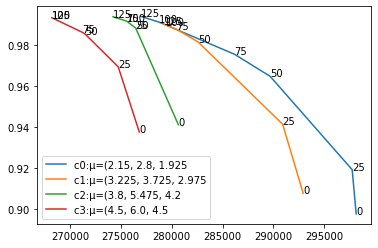

In [7]:
x=np.vectorize(lambda mm:mm.Results["AverageProfit"])(masterModels)
y=np.vectorize(lambda mm:mm.Results["ItemFillRate"])(masterModels)

import matplotlib.pyplot as plt
for c in range(0, len(masterModels)):
    plt.plot(x[c],
             y[c], label=f'c{c}:µ=({np.mean([len(s["DisruptionSupplier"]) for s in masterModels[c][0].Scenarios])}, '
                          f'{np.mean([len(s["DisruptionPlant"]) for s in masterModels[c][0].Scenarios])}, '
                          f'{np.mean([len(s["DisruptionDC"]) for s in masterModels[c][0].Scenarios])}')
    for p in range(0, len(x[c])):
        plt.text(x[c][p], y[c][p], masterModels[c][p].MissedSalePenalty)
plt.legend()
print(masterModels[0][2].Results)
print(masterModels[1][2].Results)
print(masterModels[2][1].Results)
print(masterModels[3][1].Results)